<a href="https://colab.research.google.com/github/GiPaiva/Sismos-Globais/blob/main/Earthquake_S%C3%A9rie_Temporal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sismos Globais – USGS Earthquake Catalog

Integrantes: **Giovanna Paiva Alves** e **Matheus Sanchez Duda**

O catálogo sísmico global é mantido pelo United States Geological Survey (USGS). Os dados são coletados a partir de redes de sismógrafos distribuídos mundialmente e consolidados automaticamente, passando por processos de verificação por sismólogos antes de serem disponibilizados ao público.

# Conectando ao Dataset

Para conectar ao dataset/API, usamos a biblioteca `requests` para fazer requisições HTTP e obter os dados em formato JSON. Lendo a documentação encontramos o endpoint `https://earthquake.usgs.gov/fdsnws/event/1/`, que é o caminho, como se fosse o email do dataset, para requisar os dados

In [ ]:
# É assim que o dado vem
# Os dados estão dentro de 'features' e cada evento tem 'properties'
# {'mag': 5.1, 'place': 'Tonga', 'time': 1673105434004, 'updated': 1678575105040, 'tz': None, 'url': 'https://earthquake.usgs.gov/earthquakes/eventpage/us7000j2tk', 'detail': 'https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=us7000j2tk&format=geojson', 'felt': None, 'cdi': None, 'mmi': None, 'alert': None, 'status': 'reviewed', 'tsunami': 0, 'sig': 400, 'net': 'us', 'code': '7000j2tk', 'ids': ',us7000j2tk,', 'sources': ',us,', 'types': ',origin,phase-data,', 'nst': 61, 'dmin': 2.504, 'rms': 0.76, 'gap': 54, 'magType': 'mww', 'type': 'earthquake', 'title': 'M 5.1 - Tonga'}


## Bibliotecas:

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

## Ligação com o Dataset

**"starttime": "2025-01-01", <br>
"endtime": "2025-12-30",**
<br><br>
Escolhemos a janela de 2025-01-01 / 2025-12-31 , para então pegar do ano inteiro, "Mas ué, o ano ainda não acabou como você vai pegar o dados do que ainda não chegou?", quando eu faço a requisição ele me traz o que tiver disponivel e não me retorna erro nenhum, e então se eu rodar de novo outro dia, não precisaria mudar a data ele vai me trazer o atualizado.

**"minmagnitude": 5.5,**

A escolha da magnitude foi por conta de segundo pesquisas em sites como G1 e Fundação Oswaldo Cruz:
"
Terremotos a partir de magnitude 5,5 já têm potencial para causar danos destrutivos, especialmente em edifícios mal construídos.
"

Se formos ver a escala Richter:
<table>
<tr>
<th>Magnitude (Escala Richter)</th>
<th>Efeitos Típicos</th>
</tr>
<tr>
<td>Menos de 3,5	</td><td>Geralmente não sentido, apenas registrado por sismógrafos.</td>
</tr>
<tr>
<td>3,5 - 5,4	</td><td>Frequentemente sentido, mas raramente causa danos estruturais.</td>
</tr>
<tr>
<td>5,5 - 6,0	</td><td>Danos menores em edifícios bem projetados; danos significativos em construções precárias.</td>
</tr>
<tr>
<td>6,1 - 6,9	</td><td>Pode ser devastador em áreas habitadas num raio de até 180 km.</td>
</tr>
<tr>
<td>7,0 - 7,9	</td><td>Grande terremoto, causando danos graves e destruição em zonas vastas. </td>
</tr>
<tr>
<td>8,0 ou mais</td>	<td>Pode destruir totalmente comunidades perto do epicentro e causar danos sérios num raio de centenas de quilômetros.</td>
</tr>
</table>

Como felizmente esse tipo de terremotos que chegam até essa magnitude 5.5 é até que baixas nosso dataset não estará sobrecarregado, porem só de precaução por ser um dataset bem grande e com uma taxa de atualização alta, um filtro de limite de 20000 foi colocado.

### Quais serão os dados que vamos coletar?

Não acho que um terremoto vá ter um relógio para saber quando agir, mas assim saberemos quantos por dia podem estar acontecendo ;) <br>
**'data_hora'**: Quando aconteceu? Data e a hora Completa <br>
**'data'**: Apenas a data para podermos fazer métricas <br>
**'magnitude'**: A magnitude do terremoto, para sabermos com  base na escala, o quão destrutivel foi <br>
**'profundidade_km'**: Area sentida <br> <br>
Localizações <br>
**'latitude'**: <br>
**'longitude'**: <br>
**'localizacao'**: <br>
<br>
**'tipo'**: Isso é mais pela causa, por exemplo podemos ter diferentes tipo de atividade sismicas, pode ser: vulcanica, tectônica, colapso, explosão. <br>
**'tsunami'**: Ja esse dado nos retorna um booleano se esse abalo sismico teve como consequencia um tsunami <br>

In [ ]:
print("🌍 Iniciando coleta de dados do Dataset...")
print("=" * 80)

url_base = "https://earthquake.usgs.gov/fdsnws/event/1/query"

# Parâmetros para coletar dados desde de janeiro 2025, pegando o ano todo
parametros = {
    "format": "geojson",
    "starttime": "2025-01-01",
    "endtime": "2025-12-30",
    "minmagnitude": 5.5,
    "limit": 20000
}


🌍 Iniciando coleta de dados do Dataset...


In [ ]:
print("📥 Fazendo requisição ao Dataset...")
resposta = requests.get(url_base, params=parametros)

if resposta.status_code == 200:
    print("✅ Dados obtidos com sucesso!")
    dados_json = resposta.json()

    # Extrair dados dos eventos
    lista_eventos = []

    for evento in dados_json['features']:
        props = evento['properties']
        coords = evento['geometry']['coordinates']

        # Converter timestamp para datetime, para tornar a data e hora legíveis
        timestamp = props['time'] / 1000
        data_hora = datetime.fromtimestamp(timestamp)

        evento_dict = {
            'data_hora': data_hora,
            'data': data_hora.date(),
            'magnitude': props['mag'],
            'profundidade_km': coords[2],
            'latitude': coords[1],
            'longitude': coords[0],
            'localizacao': props['place'],
            'tipo': props['type'],
            'tsunami': props['tsunami']
        }

        lista_eventos.append(evento_dict)

    # Criar DataFrame
    df = pd.DataFrame(lista_eventos)

    print(f"📊 Total de eventos coletados: {len(df)}")
    print("=" * 80)

else:
    print(f"❌ Erro na requisição: {resposta.status_code}")

📥 Fazendo requisição ao Dataset...
✅ Dados obtidos com sucesso!
📊 Total de eventos coletados: 474


# SÉRIE TEMPORAL DE SISMOS GLOBAIS

**1° Parte** <br><br>
### **Análise da Série Temporal**

- Plot completo da série temporal
- Discussão sobre tendências, padrões, ruídos e sazonalidade
- Cálculo e exibição de **médias móveis** simples com múltiplas janelas


✅ Dados processados com sucesso!
   • Período: 2025-01-01 00:00:00 até 2025-11-29 00:00:00
   • Total de eventos: 474

📊 Gerando visualizações...


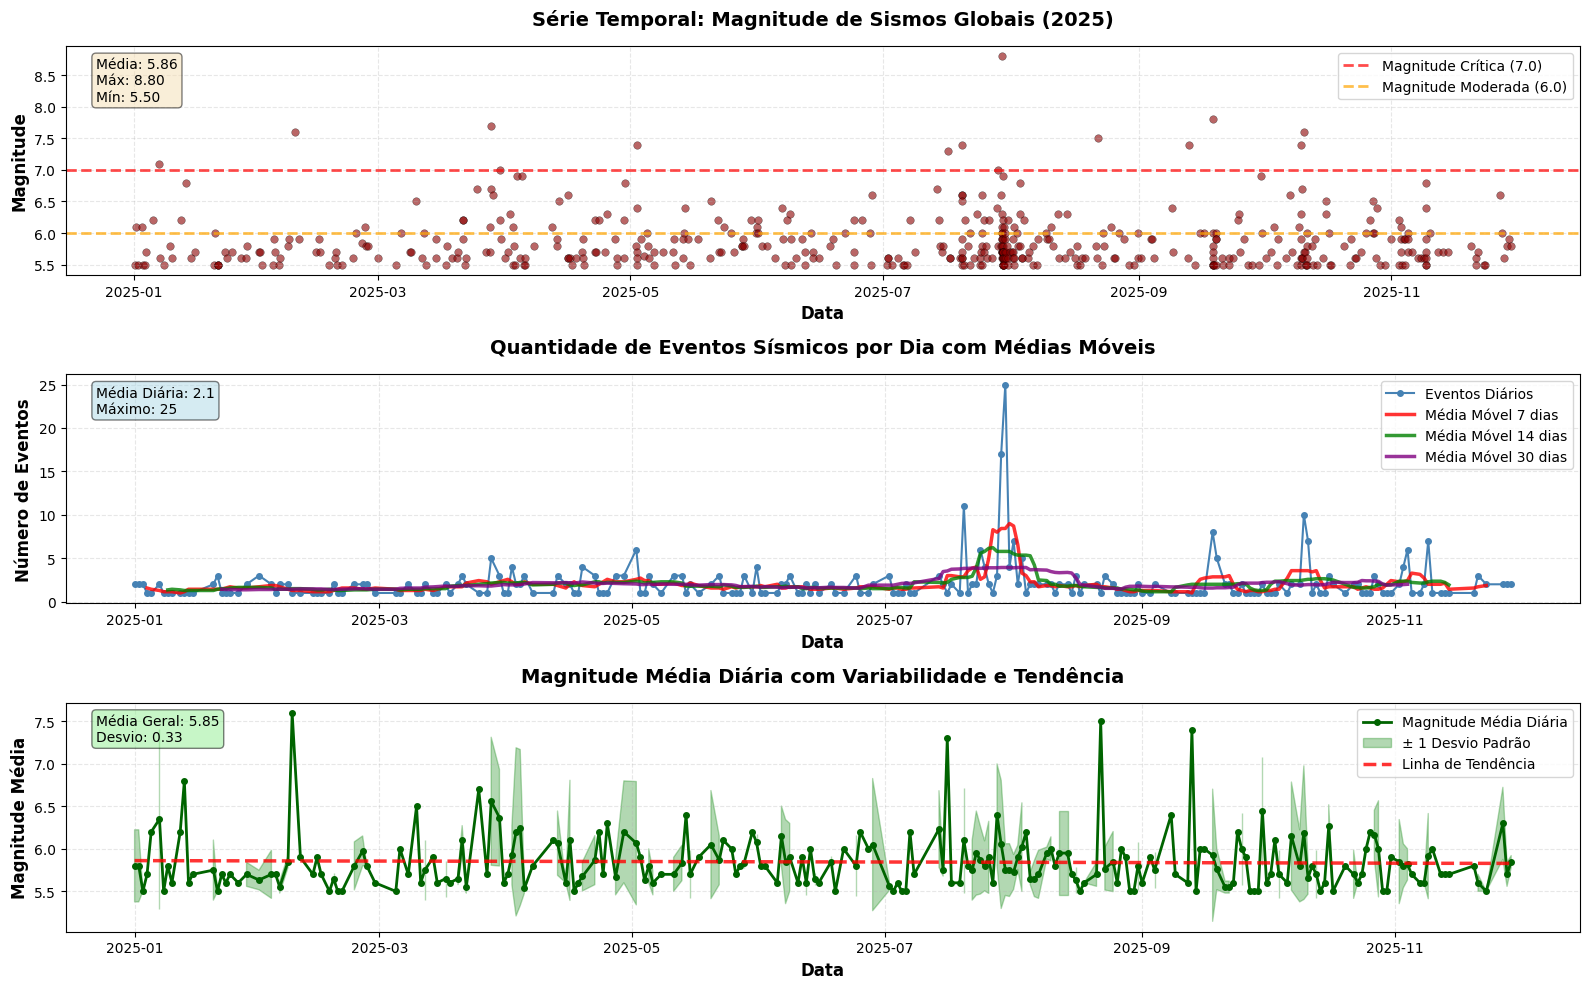


📊 Correlações de Pearson:
   • Magnitude e Tsunami: 0.59
   • Magnitude e Data: -0.00



SÉRIE TEMPORAL COMPLETA!

📊 ESTATÍSTICAS GERAIS DO DATASET:
   • Total de eventos sísmicos: 474
   • Período analisado: 2025-01-01 00:00:00 até 2025-11-29 00:00:00
   • Total de dias com registros: 229

📈 MAGNITUDE:
   • Média: 5.86
   • Mediana: 5.70
   • Desvio Padrão: 0.43
   • Mínima: 5.50
   • Máxima: 8.80

📅 EVENTOS DIÁRIOS:
   • Média de eventos por dia: 2.1
   • Máximo de eventos em um dia: 25
   • Mínimo de eventos em um dia: 1

📍 Top 10 Localizações com Mais Eventos:
localizacao
South Sandwich Islands region     14
south of the Fiji Islands          9
Pacific-Antarctic Ridge            7
Kermadec Islands region            6
west of Macquarie Island           6
Macquarie Island region            5
central Mid-Atlantic Ridge         5
southern Mid-Atlantic Ridge        4
western Indian-Antarctic Ridge     3
southern East Pacific Rise         3
Name: count, dtype: int64

🔍 Tipo de Eventos:


In [ ]:
# ============================================================================
# PROCESSAR DADOS
# ============================================================================

if df is not None and len(df) > 0:
    # Converter colunas para tipos corretos
    df['data_hora'] = pd.to_datetime(df['data_hora'])
    df['data'] = pd.to_datetime(df['data'])

    # Ordenar por data
    df = df.sort_values('data_hora')

    print("\n✅ Dados processados com sucesso!")
    print(f"   • Período: {df['data'].min()} até {df['data'].max()}")
    print(f"   • Total de eventos: {len(df)}")
    print("\n📊 Gerando visualizações...")

    # Criar figura com tamanho maior
    plt.figure(figsize=(16, 10))

    # ====================================================================
    # Magnitude ao longo do tempo
    # ====================================================================
    plt.subplot(3, 1, 1)
    plt.scatter(df['data_hora'], df['magnitude'], alpha=0.6, s=30,
                color='darkred', edgecolors='black', linewidth=0.3)
    plt.title('Série Temporal: Magnitude de Sismos Globais (2025)',
              fontsize=14, fontweight='bold', pad=15)
    plt.ylabel('Magnitude', fontsize=12, fontweight='bold')
    plt.xlabel('Data', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3, linestyle='--')

    # Linhas de referência
    plt.axhline(y=7.0, color='red', linestyle='--', linewidth=2,
                label='Magnitude Crítica (7.0)', alpha=0.7)
    plt.axhline(y=6.0, color='orange', linestyle='--', linewidth=2,
                label='Magnitude Moderada (6.0)', alpha=0.7)
    plt.legend(loc='upper right', fontsize=10)

    # Estatísticas
    media_mag = df['magnitude'].mean()
    max_mag = df['magnitude'].max()
    min_mag = df['magnitude'].min()
    plt.text(0.02, 0.95, f'Média: {media_mag:.2f}\nMáx: {max_mag:.2f}\nMín: {min_mag:.2f}',
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # ====================================================================
    # Eventos por dia com médias móveis
    # ====================================================================
    plt.subplot(3, 1, 2)

    # Agrupar eventos por dia
    eventos_por_dia = df.groupby('data').size()
    eventos_por_dia_df = eventos_por_dia.reset_index()
    eventos_por_dia_df.columns = ['data', 'quantidade']

    # Plotar eventos diários
    plt.plot(eventos_por_dia_df['data'], eventos_por_dia_df['quantidade'],
             marker='o', markersize=4, linewidth=1.5, color='steelblue',
             label='Eventos Diários')

    # Calcular médias móveis
    ma_7 = eventos_por_dia_df['quantidade'].rolling(window=7, center=True).mean()
    plt.plot(eventos_por_dia_df['data'], ma_7,
             linewidth=2.5, color='red', label='Média Móvel 7 dias', alpha=0.8)

    ma_14 = eventos_por_dia_df['quantidade'].rolling(window=14, center=True).mean()
    plt.plot(eventos_por_dia_df['data'], ma_14,
             linewidth=2.5, color='green', label='Média Móvel 14 dias', alpha=0.8)

    ma_30 = eventos_por_dia_df['quantidade'].rolling(window=30, center=True).mean()
    plt.plot(eventos_por_dia_df['data'], ma_30,
             linewidth=2.5, color='purple', label='Média Móvel 30 dias', alpha=0.8)

    plt.title('Quantidade de Eventos Sísmicos por Dia com Médias Móveis',
              fontsize=14, fontweight='bold', pad=15)
    plt.ylabel('Número de Eventos', fontsize=12, fontweight='bold')
    plt.xlabel('Data', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(loc='upper right', fontsize=10)

    # Estatísticas
    media_eventos = eventos_por_dia_df['quantidade'].mean()
    max_eventos = eventos_por_dia_df['quantidade'].max()
    plt.text(0.02, 0.95, f'Média Diária: {media_eventos:.1f}\nMáximo: {max_eventos}',
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

    # ====================================================================
    # Magnitude média diária com variação
    # ====================================================================
    plt.subplot(3, 1, 3)

    # Calcular estatísticas por dia
    mag_por_dia = df.groupby('data').agg({
        'magnitude': ['mean', 'std', 'min', 'max', 'count']
    })
    mag_por_dia.columns = ['media', 'desvio', 'minimo', 'maximo', 'count']
    mag_por_dia = mag_por_dia.reset_index()

    # Plotar magnitude média
    plt.plot(mag_por_dia['data'], mag_por_dia['media'],
             marker='o', markersize=4, linewidth=2, color='darkgreen',
             label='Magnitude Média Diária')

    # Banda de desvio padrão
    dv_cima = mag_por_dia['media'] + mag_por_dia['desvio']
    dv_baixo = mag_por_dia['media'] - mag_por_dia['desvio']
    plt.fill_between(mag_por_dia['data'], dv_baixo, dv_cima,
                     alpha=0.3, color='green', label='± 1 Desvio Padrão')

    # Linha de tendência
    dias_numericos = np.arange(len(mag_por_dia))
    coeficientes = np.polyfit(dias_numericos, mag_por_dia['media'], 1)
    tendencia = coeficientes[0] * dias_numericos + coeficientes[1]
    plt.plot(mag_por_dia['data'], tendencia,
             linewidth=2.5, linestyle='--', color='red',
             label='Linha de Tendência', alpha=0.8)

    plt.title('Magnitude Média Diária com Variabilidade e Tendência',
              fontsize=14, fontweight='bold', pad=15)
    plt.ylabel('Magnitude Média', fontsize=12, fontweight='bold')
    plt.xlabel('Data', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(loc='upper right', fontsize=10)

    # Estatísticas
    media_geral = mag_por_dia['media'].mean()
    desvio_geral = mag_por_dia['media'].std()
    plt.text(0.02, 0.95, f'Média Geral: {media_geral:.2f}\nDesvio: {desvio_geral:.2f}',
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))


    plt.tight_layout()
    plt.savefig('serie_temporal.png', dpi=300, bbox_inches='tight')
    plt.show()

    # ====================================================================
    # TSUNAMI
    # ====================================================================

    ocorreu_tsunami = 0
    nao_ocorreu_tsunami = 0
    for tsunami in df['tsunami']:
        if tsunami == 1:
            ocorreu_tsunami += 1
        else:
            nao_ocorreu_tsunami += 1

    # Correlações de pearson
    correlacao_mag_tsunami = df['magnitude'].corr(df['tsunami'])
    correlacao_mag_data = df['magnitude'].corr(df['data'])
    print(f"\n📊 Correlações de Pearson:")
    print(f"   • Magnitude e Tsunami: {correlacao_mag_tsunami:.2f}")
    print(f"   • Magnitude e Data: {correlacao_mag_data:.2f}")
    print("\n")


    # ====================================================================
    # ESTATÍSTICAS FINAIS
    # ====================================================================
    print("\n" + "=" * 80)
    print("SÉRIE TEMPORAL COMPLETA!")
    print("=" * 80)
    print(f"\n📊 ESTATÍSTICAS GERAIS DO DATASET:")
    print(f"   • Total de eventos sísmicos: {len(df)}")
    print(f"   • Período analisado: {df['data'].min()} até {df['data'].max()}")
    print(f"   • Total de dias com registros: {len(eventos_por_dia_df)}")
    print(f"\n📈 MAGNITUDE:")
    print(f"   • Média: {df['magnitude'].mean():.2f}")
    print(f"   • Mediana: {df['magnitude'].median():.2f}")
    print(f"   • Desvio Padrão: {df['magnitude'].std():.2f}")
    print(f"   • Mínima: {df['magnitude'].min():.2f}")
    print(f"   • Máxima: {df['magnitude'].max():.2f}")
    print(f"\n📅 EVENTOS DIÁRIOS:")
    print(f"   • Média de eventos por dia: {eventos_por_dia_df['quantidade'].mean():.1f}")
    print(f"   • Máximo de eventos em um dia: {eventos_por_dia_df['quantidade'].max()}")
    print(f"   • Mínimo de eventos em um dia: {eventos_por_dia_df['quantidade'].min()}")

    print(f"\n📍 Top 10 Localizações com Mais Eventos:")
    print(df['localizacao'].value_counts().head(10))

    print(f"\n🔍 Tipo de Eventos:")
    print(df['tipo'].value_counts())

    print(f"\n🔍 Tsunami:")
    print(f"   • Ocorrências: {ocorreu_tsunami}")
    print(f"   • Não Ocorrências: {nao_ocorreu_tsunami}")

    print(f"\n📆 Top 10 dias de maiores ocorrencias:")
    print(df['data'].value_counts().head(10))

    print(f"\n🔢 Resumo dos Dados:")
    print(df.describe())

    print("=" * 80)

    # Salvar DataFrame
    df.to_csv('dataset_sismos.csv', index=False)
    print("\n💾 Dataset salvo como 'dataset_sismos.csv'")

else:
    print("❌ Não foi possível coletar os dados.")


Nos 'Top 10 localizações que ocorreram eventos' todas são regiões altamente tectônicas, coerentes com hotspots sísmicos globais.

## Agora o que as nossas analises e graficos querem dizer?



### 1° Grafico



- Série Temporal: Magnitude de Sismos Globais (2025)
<p>
Analisando o primeiro grafico ele nos traz informações de média de magnitudes no decorrer do tempo, podemos reparar que a consentração de pontos em escala y, esta abaixo da faixa de magnitude moderada, tendo uma dispersão na area entre moderada e crítica
<p>
Tendo alguns outliers acima da faixa critica, entre 7 e 8.8, nos indicando que apesar da magnitude de destruição os abalos sismicos criticos são mais raros de acontecer
<p>
Tendo um grande pico magnitudes abaixo de moderadas, e um grande salto de magnetude em um curto preriodo de tempo. Esse pico foi registrado nas mídias, como o megaterremoto de Kamchatka (magnitude 8,8).
<p>
Porem a magnitude não aparenta ter relação tão grande com o tempo esses eventos não tem exatamente uma sasonalidade.

In [ ]:
correlacao_mag_data = df['magnitude'].corr(df['data'])
print(f"\n📊 Correlações de Pearson:")
print(f"   • Magnitude e Data: {correlacao_mag_data:.2f}")


📊 Correlações de Pearson:
   • Magnitude e Data: -0.00


Mas para comprovar, porque somos pessoas de pouca fé, fiz o calculo de pearson ('r' que seria o resultado):
<p>
r = 1: Correlação positiva perfeita (quando uma variável aumenta, a outra aumenta proporcionalmente).<br>
r = -1: Correlação negativa perfeita (quando uma variável aumenta, a outra diminui proporcionalmente).<br>
r = 0: Sem correlação linear (as variáveis não têm uma relação linear direta).<br>
<p>
Ou seja, de acordo com o calculo de pearson realmente não se tem correlação nenhuma entre a magnitude e a data. <br>

Fato interessante (apesar de não se perceber com o grafico 1, pois não é sobre isso):

In [ ]:
correlacao_mag_tsunami = df['magnitude'].corr(df['tsunami'])
print(f"   • Magnitude e Tsunami: {correlacao_mag_tsunami:.2f}")

   • Magnitude e Tsunami: 0.59


O tsunami tem uma certa relação com a magnitude, ou seja, se a magnetude aumenta as chances de ter um tsunami tambem aumenta.

### 2° Grafico

Esse grafico nos traz a quantidade média de abalos acontecidos por dia, sendo de 2 a 3, com alguns picos.

O principal pico que podemos perceber ocorreu no final do mês de julho e começo de mês de agosto, houve uma grande quantidade de abalos sismicos. Sendo o pico do grafico tanto na média movel de 7 dias, quanto 14 e 30 dias.
<p>
E com base em pesquisas tem um porque disso, segundo o National Geografic:
<p>
"
A percepção de um aumento na quantidade de abalos sísmicos entre o final de julho e o início de agosto de 2025 está diretamente ligada à ocorrência de um megaterremoto de magnitude 8,8 na costa leste da Rússia, em Kamchatka, no dia 30 de julho de 2025.
"
<p>
E se você verificar no grafico realmente temos novamente o que seria um outlier entre os dois meses, porem esse ponto influencia os outros geograficamente falando, contudo apenas na região, que são o que chamam de 'aftershock':
<p>
Abalos Secundários- Grandes terremotos são seguidos por uma série de tremores menores na mesma área, à medida que as placas tectônicas se reajustam após a liberação de tamanha energia. A Rússia registrou um novo tremor de magnitude 7,8 na mesma área em setembro, descrito como um "reflexo" do megaterremoto inicial.
<p>
Isso representa um período sísmico anômalo, não apenas um dia isolado.

Alem disso após esse evento a quantidade de abalos aumentou relativamente, podendo ser percebido isso tanto nesse gráfico como o anterior. Sendo que tanto em ocorrencia quanto, tendo mais pequenos picos, quanto como quantidade de eventos com uma magnetude parecida em um periodo de tempo menor.

### 3° Gráfico

Ja nesse ultimo gráfico mostra como varia a magnitude média por dia, mais o desvio padrão (variabilidade) e uma linha de tendência geral.

Nos levando a concluir com base nele:

1. A magnitude média diária é estável

- - Média geral: 5.85
- - Desvio padrão: 0.33 (baixa variação no geral).

2. Mesmo com picos de quantidade, a média se mantém estável

- - Julho–agosto tem mais eventos, mas a magnitude não explode.
- - Isso indica que houve muitos sismos, mas não necessariamente mais fortes.

3. Leve tendência crescente ao longo do ano

- - A linha de regressão sobe cerca de 0.1–0.2 pontos.
- - Sugere leve intensificação das magnitudes.

4. Períodos de maior variabilidade (área verde maior)

- - Mais evidente perto de picos de atividade.
- - Indica oscilações de força entre eventos próximos.

Despois de analisado os dados coletados são salvos em um arquivo .csv, para podermos usar em futuras analises tendo os mesmos dados e percepções.